<a href="https://colab.research.google.com/github/hjk1996/blog_post/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 목차



1. Positional Encoding
2. Multi Head Attention
3. Normalization Layer
4. Position-wise Feed Forward Network
5. Encoder Layer
6. Encoder
7. Decoder Layer
8. Decoder
9. Transformer

본 실습에서는 모델 구현과 모델 동작확인만 합니다.

모델 훈련 및 활용에 대해서는 다음 링크를 참조해주시기 바랍니다.

https://tutorials.pytorch.kr/beginner/translation_transformer.html (NN.TRANSFORMER와 TORCHTEXT로 언어 번역하기)

또한 실제 논문의 모델과 구현한 모델이 차이가 있을 수 있으니 양해바랍니다.

모델은 파이프라인 순서대로 구현했습니다.

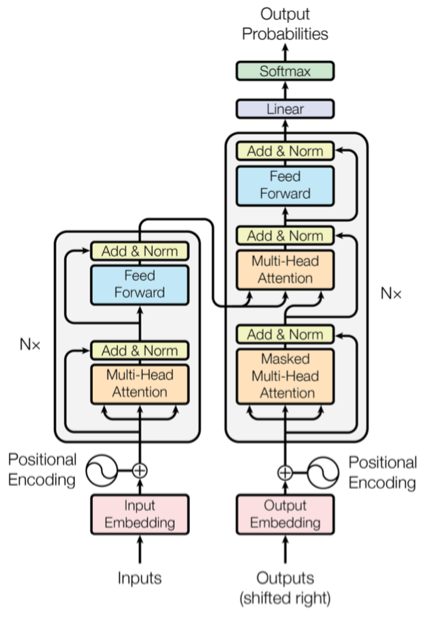

# Ref

*   Attention Is All You Need (https://arxiv.org/abs/1706.03762)
*   딥 러닝을 이용한 자연어 처리 입문 (https://wikidocs.net/31379)
*   트랜스포머 (어텐션 이즈 올 유 니드) (https://www.youtube.com/watch?v=mxGCEWOxfe8)


# 0. 환경 설정

In [ ]:
# 모델 구현에 필요한 모듈을 불러옵니다.
import torch
import torch.nn as nn
import math

In [ ]:
# cuda 사용이 가능한 지 확인하고 모델을 가동할 device를 설정합니다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **1. Positional Encoding**

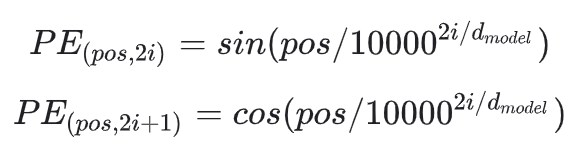

positional encoding은 시퀸스로 들어온 문장 임베딩에 위치 정보를 부여하기 위해 사용됩니다.

dmodel은 단어의 임베딩 차원 수를 의미합니다.

pos는 해당 단어가 시퀸스에서 몇 번째 단어인지를 의미하고
i는 임베딩 차원의 인덱스를 의미합니다.

만약 pos가 2, i가 3 이라면 전체 문장에서 2번째 단어 벡터의 3번째 임베딩 차원을 의미합니다.

단어의 홀수번째 임베딩에는 코사인 함수를 적용하고 짝수번째 임베딩에는 사인 함수를 적용합니다.

이번 구현에서는 단어 임베딩 차원(dmodel)을 논문과 같이 512로 설정하겠습니다.
또한 한 문장의 최대 시퀸스 길이를 256으로 설정하겠습니다.

In [ ]:
class PositionalEncoder(nn.Module):
  def __init__(self, device, d_model=512, seq_len=256, dropout_ratio=0.1):
    super(PositionalEncoder, self).__init__()

    p_e = torch.zeros(seq_len, d_model).to(device) # 포지셔널 인코딩 정보를 담을 빈 행렬을 만듭니다.

    # 분자(pos)값을 만듭니다. size([seq_len, d_model])
    numerator = torch.arange(0, seq_len).unsqueeze(1).expand(-1, d_model).to(device)
    # 분모(10000**(2i/dmodel))값을 만듭니다. size([d_model/2])
    denominator = 10000**((((2*torch.arange(0, d_model/2)))/d_model)).to(device)

    # 짝수번째 임베딩 차원에는 사인 함수를 적용하고
    # 홀수번째 임베딩 차원에는 코사인 함수를 적용합니다.
    p_e[:, ::2] = torch.sin(numerator[:, ::2] / denominator)
    p_e[:, 1::2] = torch.cos(numerator[:, 1::2] / denominator)

    self.p_e = p_e.unsqueeze(0) # 배치(batch) 차원을 추가해줍니다.
    self.p_e.requires_grad = False # gradient를 계산하지 않도록 설정합니다.
    
  def forward(self, x):
    return x + self.p_e.expand_as(x)

  
  


포지셔널 인코딩이 제대로 되는지 확인해봅시다.

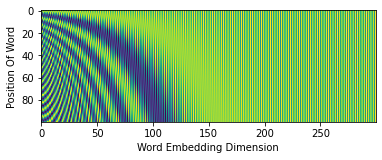

In [ ]:
import matplotlib.pyplot as plt

pos_encoder = PositionalEncoder(device, 300, 100).to(device)
ev = pos_encoder.p_e.squeeze().to('cpu').numpy()
plt.xlabel("Word Embedding Dimension")
plt.ylabel("Position Of Word")
plt.imshow(ev)


포지셔널 인코더의 순전파(forward)가 제대로 되는지 확인해봅시다.

In [ ]:
sample_x = torch.rand((64, 100, 300)).to(device)
print(sample_x.size())
encoded_x = pos_encoder(sample_x)
print(encoded_x.size())


torch.Size([64, 100, 300])
torch.Size([64, 100, 300])


# 2. Multi Head Attention

트랜스포머의 인코더의 전반적인 구조에 대해 먼저 살펴보겠습니다.

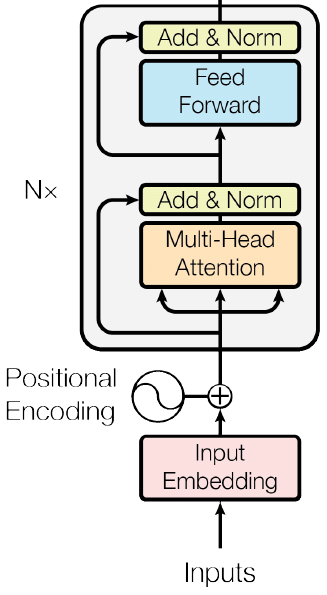

하나의 인코더 레이어는 두 개의 서브 레이어로 나눠집니다.

하나는 멀티-헤드 셀프 어텐션이고 나머지는 피드 포워드 신경망입니다.

셀프 어텐션이란 어텐션 메커니즘을 입력한 문장의 단어 벡터끼리 적용하는 것을 의미합니다.

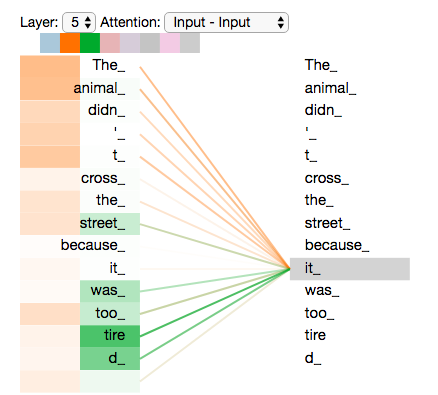

즉, 입력으로 들어온 문장의 개별 단어 사이의 어텐션 스코어를 구하는 것으로 이해하실 수 있습니다.

그러므로 쿼리(Query), 키(Key), 값(Value)모두 같은 문장의 단어 벡터입니다.

단어 벡터로 바로 어텐션 스코어를 구하지 않고 우선 가중치 행렬을 곱해 $Q$, $K$, $V$에 대한 행렬을 구합니다.

이때 곱해지는 가중치 행렬은 $Q$, $K$, $V$마다 서로 다릅니다.

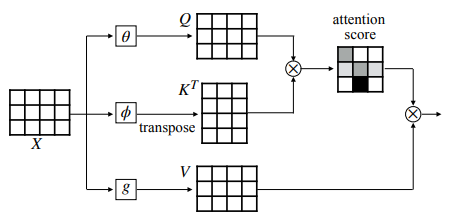

이후 $Q$와 $K^T$를 행렬곱하고 스케일링을 위해 $\sqrt{d^k}$를 나눠줍니다.

이때 $d_k$는 $d_{model}$을 attention head의 갯수로 나눈 것과 같습니다.

이 계산으로 $Q$와 $K$에 대한 attention score 행렬이 나옵니다.

attention score 행렬에 $softmax$ 활성화 함수를 취해 값을 정규화하고 $V$ 값을 곱해줍니다.

이렇게 attention을 구하는 것을 scaled dot attention이라고 부릅니다.

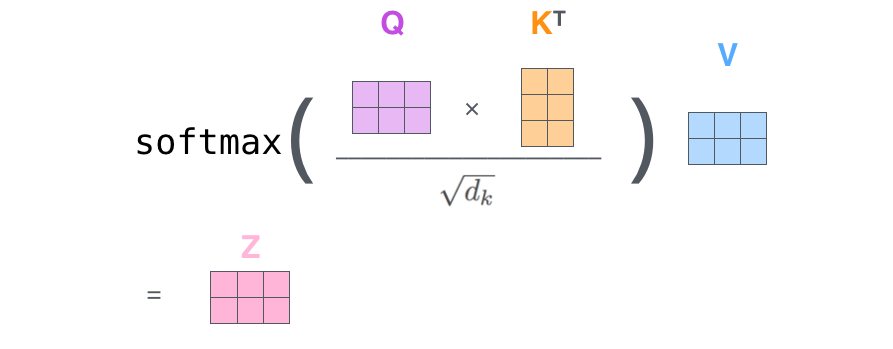


하나의 attention head에서 나오는 attention 행렬의 크기는 (시퀸스의 길이,  $d_{v}$)가 됩니다.

이때 $d_{v}$는 $d_{model}$을 attention head의 갯수로 나눈 값과 같습니다. ($d_k = d_v$)


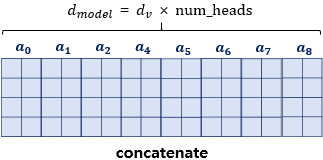


한 번에 (시퀸스의 길이, $d_{model}$)의 attention을 구하지 않는 이유는 작은 크기의 attention을 여러 개 구해서 병합하는 것이 더 좋은 성능을 낼 수 있기 때문입니다.

인코더에서 사용되는 attention의 이름이 Multi Head Attention인 이유를 이제 아시겠나요?

head의 수만큼 attention 행렬들을 구했다면 모두 통합해서 다시 (시퀸스의 길이, $d_{model}$) 크기의 attention 행렬을 구해줍니다.

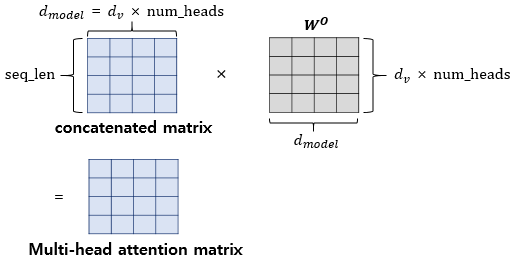

각 head에서 나온 attention을 병합한 이후 추가적인 가중치 행렬 $W^o$을 곱해줍니다. 

$W^o$의 크기는 ($d_{model}$, $d_{model}$)이기 때문에 행렬연산 이후 차원이 변하지 않습니다.


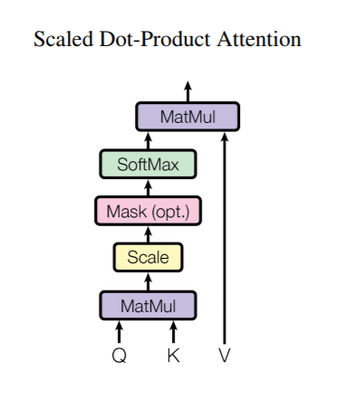

Multi Head Attention을 구현하기 전에 기초가 되는 Scaled Dot Attention을 먼저 구현하겠습니다.

In [ ]:
class ScaledDotAttention(nn.Module):
  
  def __init__(self, d_model=512, n_head=8, dropout_ratio=0.1):
    super(ScaledDotAttention, self).__init__()

    self.d_k = int(d_model / n_head) # d_k = d_v = (d_model / n_head)
    self.scale = math.sqrt(self.d_k)
    self.softmax = nn.Softmax(-1)
    self.dropout = nn.Dropout(dropout_ratio)

  def forward(self, q, k, v, mask=None):
    # Q: [batch_size, n_head,seq_len, d_model]
    # K^T: [batch_size, n_head, d_model, seq_len]
    # attn: [batch_size, n_head, seq_len, seq_len]
    attn = torch.matmul(q, k.transpose(2, 3)) / self.scale

    # 마스크가 있다면 마스킹을 해줍니다.
    if mask is not None:
      attn.masked_fill_(mask, -1e9)
    
    # 어텐션 스코어를 구하기 위해 softmax를 적용
    attn = self.softmax(attn)
    attn = self.dropout(attn)

    # V: [batch_size, n_head, seq_len, d_model]
    # output: [batch_size, n_head, seq_len, d_model]
    output = torch.matmul(attn, v)

    return output, attn

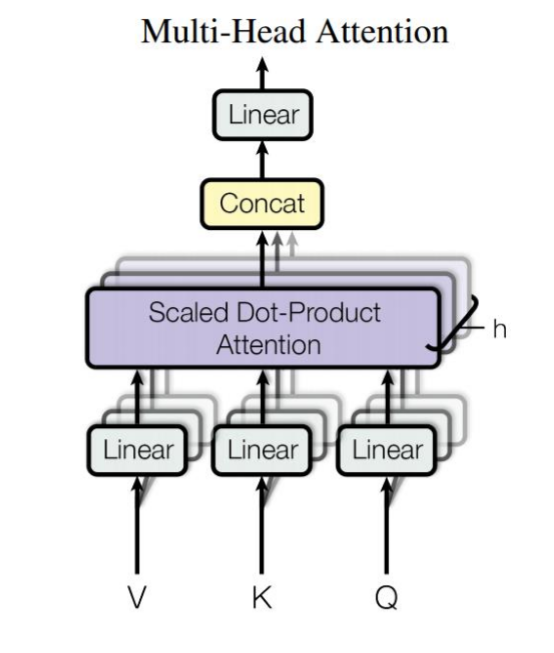

앞서 구현한 Scaled Dot Attention을 이용해서 Multi Head Attention을 구현해보도록 하겠습니다.

In [ ]:
class MultiHeadAttention(nn.Module):
  
  def __init__(self, d_model=512, seq_len=256 ,n_head=8, dropout_ratio=0.1):
    super(MultiHeadAttention, self).__init__()

    self.d_v = int(d_model / n_head)
    self.seq_len = seq_len # 시퀸스 최대 길이
    self.n_head = n_head # 헤드의 수

    # Q, K, V를 구하기 위한 가중치 행렬
    self.w_q = nn.Linear(d_model, self.d_v * n_head)
    self.w_k = nn.Linear(d_model, self.d_v * n_head)
    self.w_v = nn.Linear(d_model, self.d_v * n_head)

    # scaled dot attention과 곱해줄 행렬
    self.w_o = nn.Linear(d_model, self.d_v * n_head)

    self.scaled_dot_attention = ScaledDotAttention(d_model, n_head, dropout_ratio)

  
  def forward(self, q, k, v, mask=None):
    
    batch_size = q.size(0)

    # query, key, value를 병렬 계산한 뒤
    # d_model 차원을 head의 개수만큼 나눠 multi head를 가지게 만듭니다.
    # query, key, value: [batch_size, seq_len, d_model] -> [batch_size, n_head, seq_len, d_v]
    # d_v = d_model / n_head (하나의 헤드에서 단어 임베딩의 길이)
    q_s = self.w_q(q).view(batch_size, self.n_head, self.seq_len, -1)
    k_s = self.w_k(k).view(batch_size, self.n_head, self.seq_len, -1)
    v_s = self.w_v(v).view(batch_size, self.n_head, self.seq_len, -1)

    # 앞서 구한 query, key, value로 scaled dot attention을 구합니다.
    output, attn = self.scaled_dot_attention(q_s, k_s, v_s, mask)

    # 나눴던 multi head를 하나로 통합합니다.
    # output: [batch_size, n_head, seq_len, d_v] -> [batch_size, seq_len, d_model]
    output = output.view(batch_size, self.seq_len, -1)

    # 추가적인 가중치를 곱해줍니다.
    output = self.w_o(output)

    return output, attn


  

구현한 multi head attention 레이어가 잘 작동하는지 확인해봅시다.

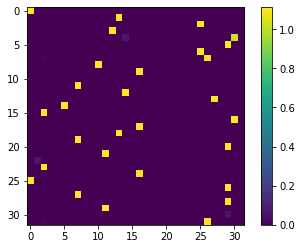

In [ ]:
tensor = torch.randint(0, 30, (16, 32, 512), dtype=torch.float32).to(device)
mha = MultiHeadAttention(512, 32, 8).to(device)
output, attn = mha(tensor, tensor, tensor)
attn.size()

head_1_attn = attn[0, 0, :, :]

plt.imshow(head_1_attn.detach().cpu().numpy())
plt.colorbar()


# **3. Normalization Layer**

정규화 레이어를 구현해봅시다.

해당 레이어에서 하는 정규화는 단어 임베딩 차원의 정규화입니다.

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, device, d_model=512, eps=1e-12):
    super(LayerNorm, self).__init__()

    # 학습가능한 가중치들
    # gamma와 beta는 스케일링 팩터입니다.
    self.gamma = nn.Parameter(torch.ones(d_model).to(device))
    self.beta = nn.Parameter(torch.zeros(d_model).to(device))
    self.eps = eps
  
  def forward(self, x):
    # x: [batch_size, seq_len, d_model]

    # mean: [batch_size, seq_len, 1]
    mean = x.mean(-1, keepdim=True)

    # std: [batch_size, seq_len, 1]
    std = x.std(-1, keepdim=True)

    # 정규화를 합니다.
    output = (x - mean) / (std + self.eps)
    # 정규화한 뒤 학습가능한 가중치들을 추가적으로 곱해줍니다.
    output = self.gamma * output + self.beta

    return output

정규화 레이어가 제대로 작동하는지 확인해봅시다.

In [ ]:
ln = LayerNorm(device, 512)
output = ln(output)
output.size()

torch.Size([16, 32, 512])

# **4. Position-wise Feed Forward Network**

Position-wise Feed Forward Network를 구현해보겠습니다.

Position-wise Feed Forward Network에서 진행되는 연산은 두 번의 행렬곱과 한 번의 활성화 함수가 전부입니다.

논문에서는 첫 번째 linear 레이어의 유닛의 수(d_ff)를 2048로 설정했습니다.

In [ ]:
class PoswiseFFN(nn.Module):

  def __init__(self, d_model=512, d_ff=2048, dropout_ratio=0.1):
    super(PoswiseFFN, self).__init__()

    self.linear1 = nn.Linear(d_model, d_ff)
    self.linear2 = nn.Linear(d_ff, d_model)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout_ratio)
  
  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.linear2(x)
    return x
    

Position-wise Feed Forward Network가 제대로 작동하는지 확인해보겠습니다.

In [ ]:
ffnn = PoswiseFFN().to(device)
output = ffnn(output)
output

tensor([[[-0.0829,  0.2538,  0.0233,  ...,  0.1905, -0.0806,  0.1854],
         [ 0.1880, -0.1062,  0.1230,  ...,  0.1474,  0.1606,  0.0185],
         [ 0.1777, -0.2761, -0.0695,  ..., -0.1135,  0.1878, -0.2067],
         ...,
         [ 0.1866, -0.2558,  0.1177,  ...,  0.3530, -0.2452, -0.1711],
         [-0.1101, -0.3397,  0.1650,  ...,  0.1449, -0.2223,  0.2084],
         [-0.2133, -0.2453, -0.2125,  ...,  0.5400, -0.1533, -0.1019]],

        [[-0.1689, -0.0408,  0.1166,  ...,  0.2910, -0.3357,  0.0393],
         [-0.3095,  0.0129,  0.0355,  ..., -0.0237, -0.3476,  0.4065],
         [-0.4295,  0.1671,  0.4918,  ...,  0.0799, -0.1694, -0.0511],
         ...,
         [-0.0245, -0.1826,  0.2609,  ...,  0.1318,  0.0143, -0.1726],
         [-0.1612, -0.1416, -0.1396,  ...,  0.3920, -0.2280, -0.0307],
         [ 0.3836, -0.3909,  0.0305,  ..., -0.0411, -0.0834, -0.1579]],

        [[-0.3775,  0.3652,  0.3333,  ...,  0.6455, -0.2600,  0.2969],
         [-0.0686, -0.2335,  0.5973,  ...,  0

# **5. Encoder Layer**


이제 앞서 구현한 레이어들로 인코더 레이어를 구현해보겠습니다.

하나의 인코더 레이어에는 두 개의 서브 레이어(Multi Head Attention, Position-wise Feed Foward Net)가 있고

 두 개의 서브 레이어 모두에서 skip connection과 정규화 레이어가 존재합니다.



In [ ]:
class EncoderLayer(nn.Module):

  def __init__(self, device, d_model=512, seq_len=256, d_ff=2048, n_head=8, dropout_ratio=0.1):
    super(EncoderLayer, self).__init__()
    
    self.mha = MultiHeadAttention(d_model, seq_len, n_head, dropout_ratio)
    self.norm1 = LayerNorm(device, d_model)

    self.pffn = PoswiseFFN(d_model, d_ff, dropout_ratio)
    self.norm2 = LayerNorm(device, d_model)

    self.dropout = nn.Dropout(dropout_ratio)
  
  def forward(self, x, mask=None):
    # attention을 구하고
    f_x, _ = self.mha(q=x, k=x, v=x, mask=mask)
    # skip connection과 정규화를 적용합니다.
    x = self.norm1(self.dropout(f_x) + x)

    # Position-wise Feed Forward Network을 통과시킨후
    f_x = self.pffn(x)
    # skip connection과 정규화를 적용합니다.
    x = self.norm2(self.dropout(f_x) + x)

    return x




인코더 레이어가 잘 작동하는지 확인해봅시다.

In [ ]:
tensor = torch.rand((16, 256, 512), dtype=torch.float32).to(device)
el = EncoderLayer(device).to(device)
output = el(tensor)
output.size()

torch.Size([16, 256, 512])

# **6. Encoder**

인코더는 여러 층으로 구성될 수 있습니다.

논문에서는 6층의 인코더를 사용합니다.

앞서 구현한 인코더 레이어로 인코더를 만들어 보겠습니다.


In [ ]:
class Encoder(nn.Module):

  def __init__(self, device, n_encoder=6, d_model=512, seq_len=256, d_ff=2048, n_head=8, dropout_ratio=0.1):
    super(Encoder, self).__init__()

    self.encoder_layers = nn.ModuleList([EncoderLayer(device, d_model, seq_len, d_ff, n_head, dropout_ratio)]*n_encoder) 

  def forward(self, x, mask=None):

    for e_l in self.encoder_layers:
      x = e_l(x, mask)

    return x

In [ ]:
encoder = Encoder(device).to(device)
enc_out = encoder(output)
enc_out.size()

torch.Size([16, 256, 512])

# 7. Decoder Layer

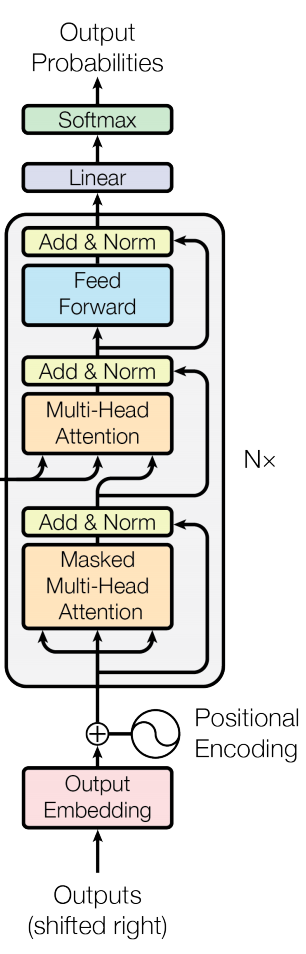

디코더 레이어는 인코더 레이어와 유사합니다.

인코더 레이어와 디코더 레이어의 차이점은 3가지입니다.

1. 서브 레이어가 3개이다. (인코더는 2개)
2. Masked Multi Head Attention에서 패딩에 대한 마스킹에 더해 앞단어가 뒷단어를 attention하지 못하도록 마스킹한다. (인코더에서는 패딩만 마스킹함)

  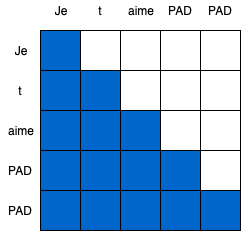
  
  (출처: https://trungtran.io/2019/04/29/create-the-transformer-with-tensorflow-2-0/)
3. Multi Head Attention에서 key와 value는 인코더의 출력값이 된다.

그럼 이제 디코더 레이어를 구현해보겠습니다.

In [ ]:
class DecoderLayer(nn.Module):

  def __init__(self, device, d_model=512, seq_len=256, d_ff=2048, n_head=8, dropout_ratio=0.1):
    super(DecoderLayer, self).__init__()

    self.self_attention = MultiHeadAttention(d_model, seq_len, n_head)
    self.norm1 = LayerNorm(device, d_model)
    self.encoder_attention = MultiHeadAttention(d_model, seq_len, n_head)
    self.norm2 = LayerNorm(device, d_model)
    self.pffn = PoswiseFFN(d_model, d_ff)
    self.norm3 = LayerNorm(device, d_model)
    self.dropout = nn.Dropout(dropout_ratio)
  
  def __call__(self, x, enc_out, src_mask, trg_mask):

    # self attention
    f_x, _ = self.self_attention(x, x, x, trg_mask)
    # layer normalization and skip connection
    x = self.norm1(self.dropout(f_x) + x)

    # 인코더의 출력값을 Key와 Value로 사용하고 디코더의 출력값을 Query로 사용
    f_x, _ = self.encoder_attention(x, enc_out, enc_out, src_mask)
    # layer normalization and skip connection
    x = self.norm2(self.dropout(f_x) + x)

    f_x = self.pffn(x)
    x = self.norm3(self.dropout(f_x) + x)

    return x




# **8. Decoder**

인코더 레이어를 쌓는 것처럼 디코더 레이어를 쌓아줍시다.

In [ ]:
class Decoder(nn.Module):

  def __init__(self, device, n_decoder=6, d_model=512, seq_len=256, d_ff=2048, n_head=8, dropout_ratio=0.1):
    super(Decoder, self).__init__()

    self.decoder_layers = nn.ModuleList([DecoderLayer(device, d_model, seq_len, d_ff, n_head, dropout_ratio)]*n_decoder)

  def __call__(self, x, enc_out, src_mask, trg_mask):

    for d_l in self.decoder_layers:
      x = d_l(x, enc_out, src_mask, trg_mask)

    return x

# **9. Transformer**

이제 앞서 만들었던 모든 레이어들을 통합해서 트랜스포머를 만드는 것만 남았습니다.

In [ ]:
class Transformer(nn.Module):

  def __init__(self, device, input_dim, output_dim, src_pad_idx, trg_pad_idx, 
               n_layer=6, d_model=512, seq_len=256, d_ff=2048, n_head=8, dropout_ratio=0.1):
    super(Transformer, self).__init__()

    """
    n_layer: 인코더와 디코더의 레이어 수
    d_model: 임베딩 차원 수
    seq_len: 문장의 최대 길이
    d_ff: 피드포워드넷의 은닉 차원의 수
    n_head:: 멀티 헤드의 수
    input_dim: 입력 언어의 vocabulary 크기
    output_dim: 출력 언어의 vocabulary 크기
    src_pad_idx: 입력 언어 vocabulary의 패딩 인덱스
    trg_pad_idx: 출력 언어 vocabulrary의 패딩 인덱스
    """

    self.device = device

    # 입력 언어 vocabulrary의 padding에 대한 인덱스
    self.src_pad_idx = src_pad_idx 
    # 출력 언어 vocabulrary의 padding에 대한 인덱스
    self.trg_pad_idx = trg_pad_idx 

    # 입력 언어 임베딩 레이어
    self.src_embedding = nn.Embedding(input_dim, d_model) 
    # 입력 언어 포지셔널 인코딩
    self.enc_pos_embedding = PositionalEncoder(device, d_model, seq_len)
    # 인코더 
    self.encoder = Encoder(device, n_layer, d_model, seq_len, d_ff, n_head, dropout_ratio) 

    # 출력 언어 임베딩 레이어
    self.trg_embedding = nn.Embedding(output_dim, d_model) 
    # 출력 언어 포지셔널 인코딩
    self.dec_pos_embedding = PositionalEncoder(device, d_model, seq_len) 
    # 디코더
    self.decoder = Decoder(device, n_layer, d_model, seq_len, d_ff, n_head, dropout_ratio) 

    # 출력 언어의 vocabulrary 크기만큼 출력 유닛의 수 설정
    self.linear = nn.Linear(d_model, output_dim) 

  def forward(self, src, trg):

    src_mask = self.create_src_mask(src)
    src_embedding = self.src_embedding(src)
    src_embedding = self.enc_pos_embedding(src_embedding)
    enc_out = self.encoder(src_embedding, src_mask)

    trg_mask = self.create_trg_mask(trg)
    trg_embedding = self.trg_embedding(trg)
    trg_embedding = self.dec_pos_embedding(trg_embedding)
    dec_out = self.decoder(trg_embedding, enc_out, src_mask, trg_mask)

    output = self.linear(dec_out)

    return output

  # src_embedding에 대한 마스크 생성
  def create_src_mask(self, src):
    
    # 시퀸스에서 정수로 표현된 각 단어가 padding index에 해당하지 않으면 True
    # broadcasting을 위해 차원을 늘려줌
    # src: [batch_size, src_len] -> src_mask: [batch_size, 1, 1, src_len]
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    return src_mask

  # trg_embedding에 대한 마스크 생성
  def create_trg_mask(self, trg):

    # 패딩에 대한 마스크
    # trg: [batch_size, trg_len] -> trg_mask1: [batch_size, 1, 1, trg_len]
    trg_mask1 = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

    
    trg_len = trg.size(1) # 출력 언어의 시퀸스 길이

    # 다음 단어를 알 수 없도록 마스킹합니다.
    # trg_mask2: [trg_len, trg_len]
    trg_mask2 = torch.tril(torch.ones(trg_len, trg_len, device=self.device)).bool()

    # trg_mask1과 trg_mask2가 모두 True인 영역만 True로 설정합니다.
    # trg_mask: [batch_size, 1, trg_len, trg_len]
    trg_mask = torch.logical_and(trg_mask1, trg_mask2)

    return trg_mask

트랜스포머가 제대로 작동하는지 확인해봅시다.

In [ ]:
transformer = Transformer(device, 1000, 1000, 1, 1).to(device)

In [ ]:
test_src = torch.randint(0, 10, (16, 256)).to(device)
test_trg = torch.randint(0, 10, (16, 256)).to(device)
output = transformer(test_src, test_trg)
output.size()

torch.Size([16, 256, 1000])